# Análisis de textos

In [8]:
%pip install num2words

Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import num2words
import re, unicodedata, inflect
import nltk
from gensim.models import Word2Vec
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from joblib import dump, load



In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
RECALL = "Recall:"
PRECISION = "Precision:"
F1 = "F1:"

In [12]:
# Configuring pandas to show all cell content
pd.set_option("display.max_colwidth", None)

In [13]:
# Downloading stopwords
nltk.download("punkt")
nltk.download("stopwords")
stop_words = stopwords.words("spanish")

[nltk_data] Downloading package punkt to /home/leo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/leo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
ods_df = pd.read_csv("../../data/cat_6716.csv")

In [15]:
ods_df["sdg"].value_counts(dropna=False, normalize=True)

6     0.542161
16    0.263505
7     0.194335
Name: sdg, dtype: float64

In [16]:
ods_df["Textos_espanol"] = ods_df["Textos_espanol"].astype(str)

## Preparación de datos

Para poder realizar el pre-procesamiento de los datos, es recomendable pasar por tres etapas:
* Limpieza de los datos.
* Tokenización.
* Normalización.

<span style="color:red">!!! Antes de ver la solución, revisa alternativas para realizar las tres etapas previas.</span>

Para mayor información, pueden consultar el [siguiente artículo](https://medium.com/datos-y-ciencia/preprocesamiento-de-datos-de-texto-un-tutorial-en-python-5db5620f1767
).

### Limpieza de los datos

In [17]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    return [word.lower() for word in words]

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = num2words.num2words(int(word), lang='es')
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    return [word for word in words if word not in stop_words]

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

### Tokenización

In [18]:
ods_df["Textos_espanol"] = ods_df["Textos_espanol"].apply(word_tokenize).apply(preprocessing).apply(" ".join)
ods_df.sample(5)

,Textos_espanol,sdg
458,pronostica disminucion escorrentia dos rios principales georgia iorigabirri alazaniganyh impacto potencial agricultura regadio suministro agua potable recarga agua subterranea tambien influenciada reduccion flujo agua superficial influencia reduccion escorrentia asi disminucion calidad aguas superficiales subterraneas cuenca kura evalua negativa parte occidental pais pronostica impacto reduccion recarga aguas subterraneas sera negativo,6
866,ello necesitan programas dirigidos modificar comportamiento especificaciones equipos herramientas pueden considerarse tarifas servicios interrumpibles tarifas tiempo uso educacia3n materia eficiencia energatica existe necesidad real educar poblacia3n papel individuo desarrollo sostenible energaas renovables eficiencia energatica,7
903,obstante debe reconocerse incluso aplazamiento plazos cronogramas lpt siguen siendo impresionantes incumplimiento meta dos mil ocho deberia haber sido sorpresa total politicas gemelas acceso universal costos altos tarifas bajas ingresos bajos concesionarios conducen situacion dificil incluso contabilizan subsidios reciben empresas servicios publicos zerriffi dos mil siete costos operacion administracion capital reposicion ser cubiertos proveedores servicios largo plazo22 predominio electrificacion red incluso puede esperar uso productivo pequeno futuro cercano causando problema comprometiendo aun mas equilibrio financiero empresas servicios publicos promover usos productivos electricidad aumentar ingresos empresas servicios publicos vital garantizar exito largo plazo instalaciones electrificacion vez lpt llegue fin zerriffi dos mil siete estudio ex post beneficios lpt encontro gracias programa condiciones vida hogares mejorado significativamente,7
311,estacion israeli investigacion oceanografica limnologica controla cantidad calidad agua largo costa mar mediterraneo autoridad parques naturaleza npa controla calidad agua rios nombre ministerio medio ambiente mekorot autoridades locales controlan calidad agua potable bajo supervision ministerio sanidad ministerio sanidad controla calidad efluentes uso sector agricola,6
94,ejemplo nivel subnacional controles inundaciones urbanas preservacion restauracion ecologica aguas urbanas menudo entran conflicto pasado enfasis exclusivo metodos estructurales control inundaciones condujo destruccion habitat asi deterioro calidad agua objetivos control inundaciones preservacion ecologica planificacion espacial convergen impacto areas politica puede minimizarse requiere compromiso largo plazo partes interesadas relevantes extiende mas alla cambios politicos calendarios electorales,6


### Normalización

# Entrenamiento

In [19]:
# The param 'stratify' is useful to guarantee label proportions on train and test sets
X_train, X_test, y_train, y_test = train_test_split(ods_df[["Textos_espanol"]], ods_df["sdg"], test_size=0.3, stratify=ods_df["sdg"], random_state=1)

In [20]:
X_train_tokens = [nltk.word_tokenize(text) for text in X_train]
X_test_tokens = [nltk.word_tokenize(text) for text in X_test]

In [21]:
pd.Series(y_train).value_counts(normalize=True)

6     0.542373
16    0.263653
7     0.193974
Name: sdg, dtype: float64

In [22]:
pd.Series(y_test).value_counts(normalize=True)

6     0.541667
16    0.263158
7     0.195175
Name: sdg, dtype: float64

## Text vectorization

In [23]:
bow = CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [24]:
X_bow = bow.fit_transform(X_train["Textos_espanol"])

In [25]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [26]:
X_tfidf = tfidf.fit_transform(X_train["Textos_espanol"])

## Training a model with BoW

In [27]:
bow_model = RandomForestClassifier(random_state=2)

In [28]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<AxesSubplot: >

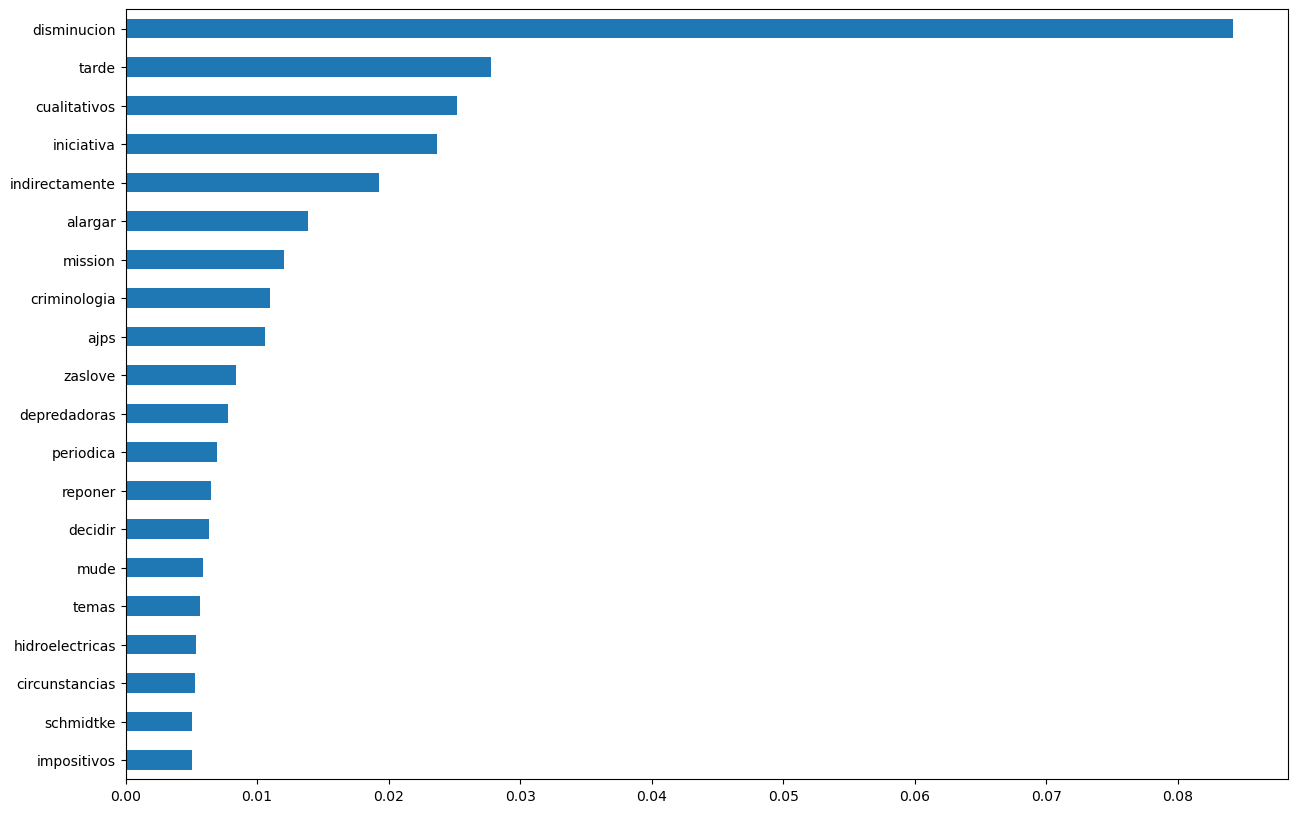

In [29]:
# Feature importance in tree models is an indicator on how relevant is a feature for taking the decision by the model
pd.Series(bow_model.feature_importances_, index=bow.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [30]:
bow_estimators = bow_model.estimators_
print("Number of trees:", len(bow_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 72.35


In [31]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test["Textos_espanol"]))

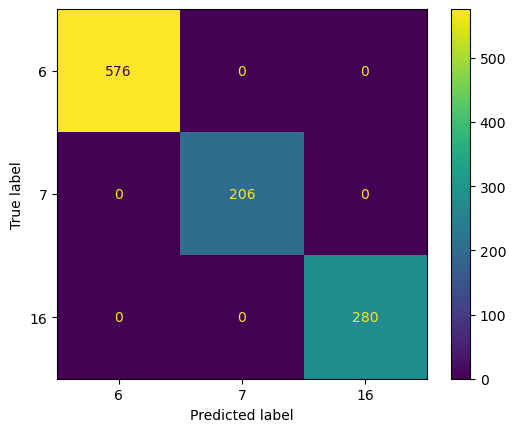

In [32]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

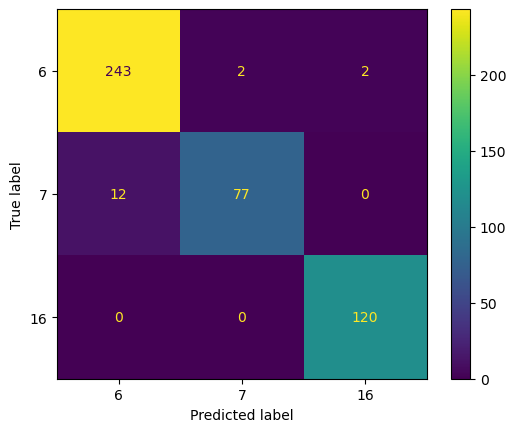

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [34]:
print(PRECISION, precision_score(y_train, y_train_bow_predict, average="weighted"))
print(RECALL, recall_score(y_train, y_train_bow_predict, average="weighted"))
print(F1, f1_score(y_train, y_train_bow_predict, average="weighted"))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [35]:
print(PRECISION, precision_score(y_test, y_test_bow_predict, average="weighted"))
print(RECALL, recall_score(y_test, y_test_bow_predict, average="weighted"))
print(F1, f1_score(y_test, y_test_bow_predict, average="weighted"))

Precision: 0.9652545897292087
Recall: 0.9649122807017544
F1: 0.9642962452543506


### Model selection

In [36]:
pipeline = Pipeline(steps = [
    ("vectorizer", CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)),
    ("classifier", RandomForestClassifier(random_state=4)),
])
dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']

In [37]:
param_grid = {
    "vectorizer": [CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words), TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words)],
    "vectorizer__lowercase": [True, False],
    "classifier__n_estimators": [50, 100],
    "classifier__criterion": ['gini', 'entropy'],
    "classifier__max_depth": [25, 50, 75, 100], 
}


In [38]:
search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, scoring=["precision", "recall", "f1"], refit="f1", cv=7, return_train_score=True, verbose=1, random_state=5)


In [46]:
search.fit(X_train["Textos_espanol"], y_train)
dump(search, "fitted_pipeline.joblib")

Fitting 7 folds for each of 10 candidates, totalling 70 fits


['fitted_pipeline.joblib']

In [40]:
search.best_params_

{'vectorizer__lowercase': False,
 'vectorizer': CountVectorizer(stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                             'del', 'se', 'las', 'por', 'un', 'para', 'con',
                             'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                             'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                             'porque', ...],
                 tokenizer=<function word_tokenize at 0x7fbd93c6e950>),
 'classifier__n_estimators': 100,
 'classifier__max_depth': 100,
 'classifier__criterion': 'gini'}

In [41]:
search.best_score_

nan

In [42]:
y_train_search_predict = search.best_estimator_.predict(X_train["Textos_espanol"])
y_test_search_predict = search.best_estimator_.predict(X_test["Textos_espanol"])


In [43]:
print(PRECISION, precision_score(y_train, y_train_search_predict, average="weighted"))
print(RECALL, recall_score(y_train, y_train_search_predict, average="weighted"))
print(F1, f1_score(y_train, y_train_search_predict, average="weighted"))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [44]:
print(PRECISION, precision_score(y_test, y_test_search_predict, average="weighted"))
print(RECALL, recall_score(y_test, y_test_search_predict, average="weighted"))
print(F1, f1_score(y_test, y_test_search_predict, average="weighted"))

Precision: 0.9632026219707408
Recall: 0.9627192982456141
F1: 0.9621527299887555


# Predicción y guardado de data

In [47]:
pipe_loaded = load("./fitted_pipeline.joblib")
ods_df_unlabeled = pd.read_csv("../../data/SinEtiquetatest_cat_6716.csv")
#Predict the labels of the unlabeled data
y_unlabeled_predict = pipe_loaded.best_estimator_.predict(ods_df_unlabeled["Textos_espanol"])
#Add the predicted labels to the unlabeled data
ods_df_unlabeled["sdg"] = y_unlabeled_predict
#Save the labeled data
ods_df_unlabeled.to_csv("../../data/Predicted.csv", index=False)
